<a href="https://colab.research.google.com/github/salwaa-hub/tubes_machinelearning/blob/main/tubes_machinelearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tugas Besar Machine Learning Semester 4 - Salwa Salsabila Daffa'atulhaq (4.33.23.2.25)**

***Long Short-Term Memory***

1. Eksplorasi Data Awal

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# --- Info Dataset ---
print("\n=== STRUKTUR DATASET ===")
print(df.info())

# --- Load Data ---
df = pd.read_csv("weatherHistory.csv")

# --- Konversi Kolom Waktu ---
df["Formatted Date"] = pd.to_datetime(df["Formatted Date"], utc=True)

# --- Urutkan Berdasarkan Waktu ---
df.sort_values("Formatted Date", inplace=True)
df.reset_index(drop=True, inplace=True)

# --- Contoh Record (Baris Data) ---
print("\n=== CONTOH RECORD (5 BARIS PERTAMA) ===")
print(df.head())  # Tampilkan contoh data (baris-baris awal)

# --- Statistik Deskriptif ---
print("\n=== STATISTIK DESKRIPTIF ===")
print(df.describe())

# --- Cek Missing Values ---
print("\n=== JUMLAH MISSING VALUES ===")
print(df.isnull().sum())

# --- Split Data (Contoh Pemisahan Training dan Testing) ---
split_ratio = 0.8
split_index = int(len(df) * split_ratio)
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

# --- Analisis Dimensi Dataset ---
print("\n=== ANALISIS DIMENSI DATASET ===")
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Total kolom dalam train data: {train_data.shape[1]}")
print(f"Total kolom dalam test data: {test_data.shape[1]}")

# --- Analisis Fitur ---
print("\n=== ANALISIS FITUR ===")
print(f"Total fitur (termasuk target): {len(train_data.columns)}")
print(f"Fitur numerik: {len(train_data.select_dtypes(include=[np.number]).columns)}")
print(f"Fitur kategorikal: {len(train_data.select_dtypes(include=['object']).columns)}")


=== STRUKTUR DATASET ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Formatted Date            96453 non-null  datetime64[ns, UTC]
 1   Summary                   96453 non-null  object             
 2   Precip Type               95936 non-null  object             
 3   Temperature (C)           96453 non-null  float64            
 4   Apparent Temperature (C)  96453 non-null  float64            
 5   Humidity                  96453 non-null  float64            
 6   Wind Speed (km/h)         96453 non-null  float64            
 7   Wind Bearing (degrees)    96453 non-null  float64            
 8   Visibility (km)           96453 non-null  float64            
 9   Loud Cover                96453 non-null  float64            
 10  Pressure (millibars)      96453 non-null  float64       

2. Praproses Data

In [ ]:
# Drop kolom non-numerik
df.drop(columns=["Summary", "Precip Type", "Daily Summary"], inplace=True)

# Hapus missing values
df.dropna(inplace=True)

# Normalisasi fitur numerik
from sklearn.preprocessing import MinMaxScaler

# Inisialisasi dan fit scaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df.drop(columns=["Formatted Date"]))

# Gabungkan kembali ke DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=df.columns[1:])
df_scaled["Formatted Date"] = df["Formatted Date"].values
df_scaled = df_scaled[["Formatted Date"] + list(df_scaled.columns[:-1])]

3. Heatmap Korelasi dan Feature Selected

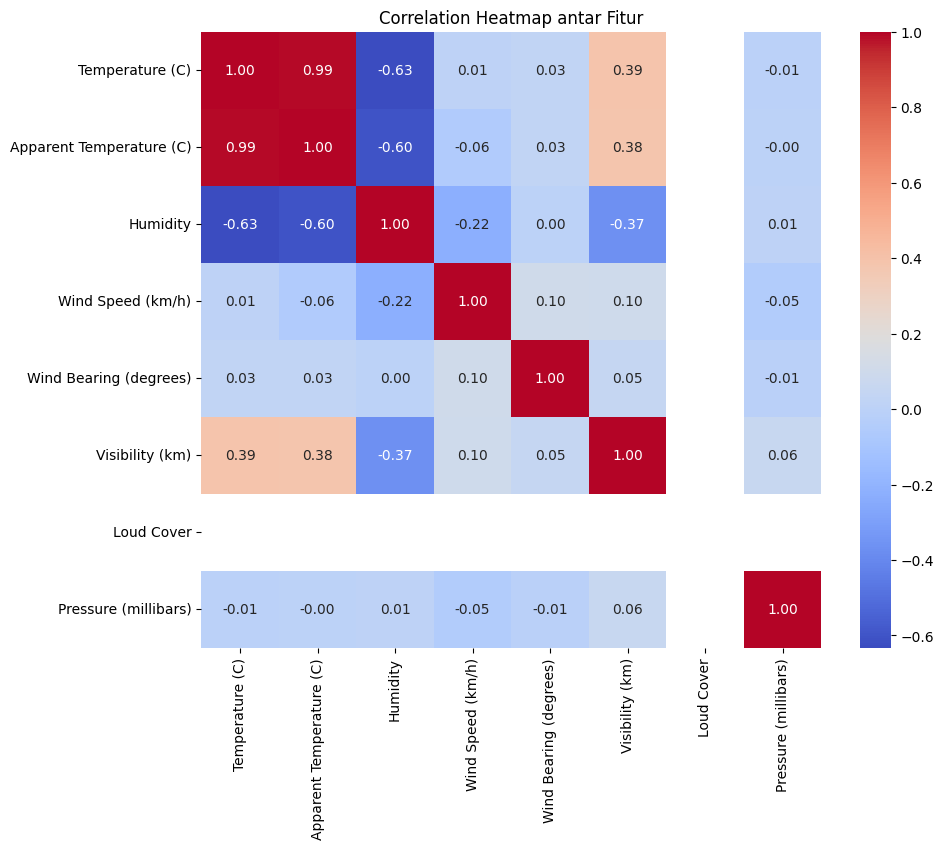


✅ Fitur yang dipilih berdasarkan korelasi (|corr| > 0.2) terhadap 'Temperature (C)':
['Apparent Temperature (C)', 'Humidity', 'Visibility (km)']


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ambil hanya kolom numerik (tanpa "Formatted Date" jika ada)
numeric_df = df.select_dtypes(include=["float64", "int64"])

# ===== 1. Heatmap Korelasi =====
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap antar Fitur")
plt.show()

# ===== 2. Feature Selection berdasarkan korelasi terhadap 'Temperature (C)' =====
correlation_matrix = numeric_df.corr()
target_corr = correlation_matrix["Temperature (C)"].abs().sort_values(ascending=False)

# Threshold korelasi minimum (misal > 0.2)
threshold = 0.2
selected_features = target_corr[target_corr > threshold].index.tolist()

# Buang target dari daftar fitur input
if "Temperature (C)" in selected_features:
    selected_features.remove("Temperature (C)")

print("\n✅ Fitur yang dipilih berdasarkan korelasi (|corr| > 0.2) terhadap 'Temperature (C)':")
print(selected_features)

# (Opsional) Simpan data hasil seleksi fitur untuk tahap berikutnya
df_selected = df[selected_features + ["Temperature (C)", "Formatted Date"]]

4. Window Data untuk LSTM

In [ ]:
import numpy as np
import pandas as pd

def create_lstm_dataset(data, look_back=24):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i])
        y.append(data[i][0])  # Kolom suhu = kolom 0
    return np.array(X), np.array(y)

# Konfigurasi look_back window
look_back = 24

# Ambil semua kolom kecuali waktu
data_values = df_scaled.drop(columns=["Formatted Date"]).values
feature_names = df_scaled.drop(columns=["Formatted Date"]).columns.tolist()

# Buat dataset LSTM
X, y = create_lstm_dataset(data_values, look_back)

# Tampilkan bentuk data
print("Bentuk X:", X.shape)
print("Bentuk y:", y.shape)

# Tampilkan X[0] sebagai DataFrame (tabel)
df_window = pd.DataFrame(X[0], columns=feature_names)
df_window.index = [f"Jam {i+1}" for i in range(look_back)]

print("\n🪟 Contoh input window pertama (X[0]) sebagai tabel (24 jam × fitur):")
display(df_window)  # jika di Jupyter/Colab
# Jika display tidak berfungsi:
# print(df_window)

# Tampilkan target suhu (scaled)
print("\n🎯 Target suhu (scaled) untuk window pertama (y[0]):")
print(y[0])

# Kembalikan ke suhu asli (jika scaler tersedia)
try:
    y_inverse = scaler.inverse_transform(y.reshape(-1, 1))
    print("\n🎯 Target suhu asli (dalam °C) untuk y[0]:", y_inverse[0][0])
except Exception as e:
    print("\n⚠️ Tidak bisa inverse transform — pastikan scaler sudah didefinisikan sebelumnya.")

Bentuk X: (96429, 24, 8)
Bentuk y: (96429,)

🪟 Contoh input window pertama (X[0]) sebagai tabel (24 jam × fitur):


,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
Jam 1,0.362884,0.352912,0.89,0.268028,0.389972,0.620,0.0,0.971597
Jam 2,0.372334,0.365007,0.85,0.260212,0.387187,0.615,0.0,0.971110
Jam 3,0.380524,0.366250,0.82,0.317196,0.389972,0.615,0.0,0.970842
Jam 4,0.381244,0.380582,0.82,0.226929,0.389972,0.615,0.0,0.970546
Jam 5,0.372694,0.372380,0.86,0.218356,0.373259,0.615,0.0,0.969992
Jam 6,0.373054,0.367492,0.85,0.249117,0.415042,0.620,0.0,0.969132
Jam 7,0.389524,0.376108,0.79,0.321987,0.389972,0.624,0.0,0.968988
Jam 8,0.387094,0.364510,0.81,0.398134,0.378830,0.623,0.0,0.968329
Jam 9,0.389164,0.370806,0.80,0.362834,0.389972,0.696,0.0,0.968281
Jam 10,0.397804,0.381493,0.82,0.358296,0.389972,0.620,0.0,0.968377



🎯 Target suhu (scaled) untuk window pertama (y[0]):
0.4413644136441365

⚠️ Tidak bisa inverse transform — pastikan scaler sudah didefinisikan sebelumnya.


5. Split Data Train/Test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

6. Bangun dan Latih Model LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


965/965 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.0090 - mae: 0.0532 - val_loss: 4.9700e-04 - val_mae: 0.0172
Epoch 2/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - loss: 6.0336e-04 - mae: 0.0188 - val_loss: 4.8908e-04 - val_mae: 0.0172
Epoch 3/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 4.9211e-04 - mae: 0.0167 - val_loss: 3.8750e-04 - val_mae: 0.0152
Epoch 4/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 4.3226e-04 - mae: 0.0156 - val_loss: 3.2299e-04 - val_mae: 0.0139
Epoch 5/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 4.0326e-04 - mae: 0.0147 - val_loss: 4.8299e-04 - val_mae: 0.0174
Epoch 6/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 3.9839e-04 - mae: 0.0146 - val_loss: 3.7239e-04 - val_mae: 0.0150
Epoch 7/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 3.8169e-04 - mae: 0.0143 - val_loss: 3.0434e-04 - val_mae: 0.0132
Epoch 8/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 3.5024e-04 - mae: 0.0135 - val_loss: 3.7538e-04 - val_mae

7. Simpan Model (.h5)

In [ ]:
model.save("lstm_temperature_model.h5")

8. Inverse Transform ke Skala Celcius

In [ ]:
# Prediksi
y_pred = model.predict(X_test)

# Siapkan array untuk inverse transform
y_pred_full = np.zeros((len(y_pred), X.shape[2]))
y_pred_full[:, 0] = y_pred[:, 0]
y_pred_celsius = scaler.inverse_transform(y_pred_full)[:, 0]

y_test_full = np.zeros((len(y_test), X.shape[2]))
y_test_full[:, 0] = y_test
y_test_celsius = scaler.inverse_transform(y_test_full)[:, 0]

603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


9. Evaluasi: RMSE & MAE dalam Celcius

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_celsius, y_pred_celsius)
rmse = np.sqrt(mean_squared_error(y_test_celsius, y_pred_celsius))

print(f"MAE  (°C) = {mae:.4f}")
print(f"RMSE (°C) = {rmse:.4f}")

MAE  (°C) = 0.6427
RMSE (°C) = 0.8756


10. Visualisasi Prediksi vs Aktual

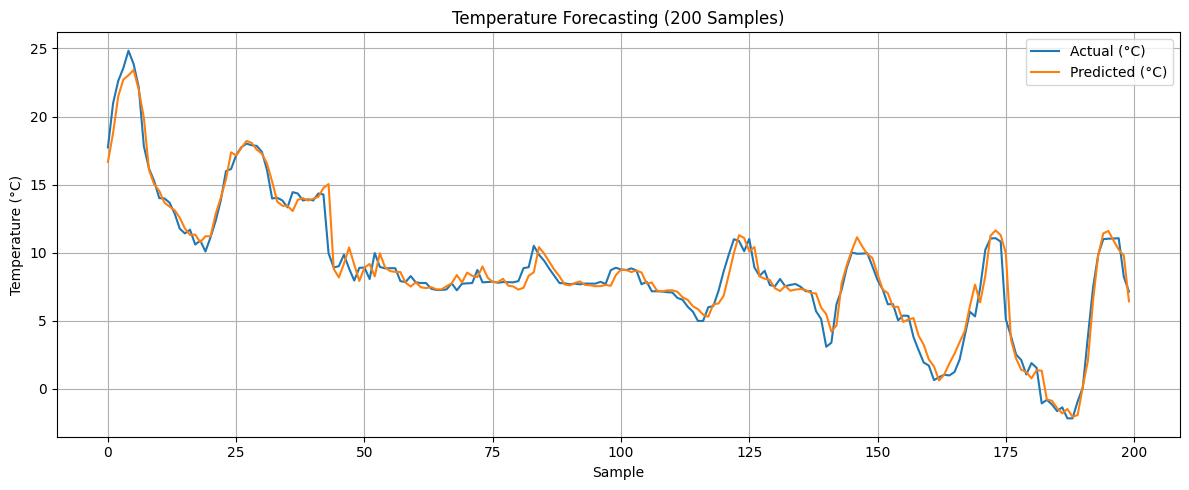

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_celsius[:200], label='Actual (°C)')
plt.plot(y_pred_celsius[:200], label='Predicted (°C)')
plt.title("Temperature Forecasting (200 Samples)")
plt.xlabel("Sample")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

11. Visualisasi Training History (Loss & MAE)

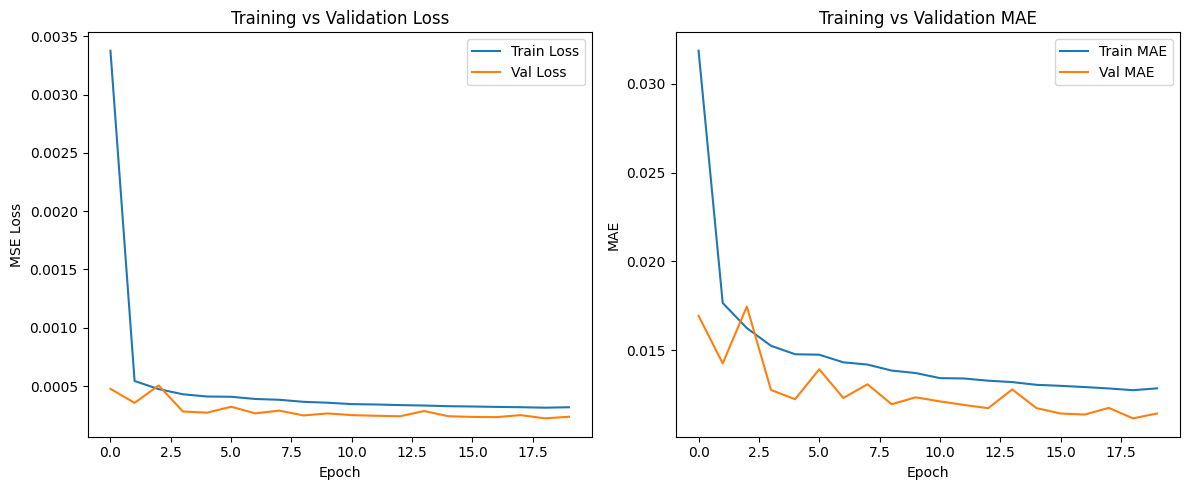

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

12. Visualisasi Distribusi Error

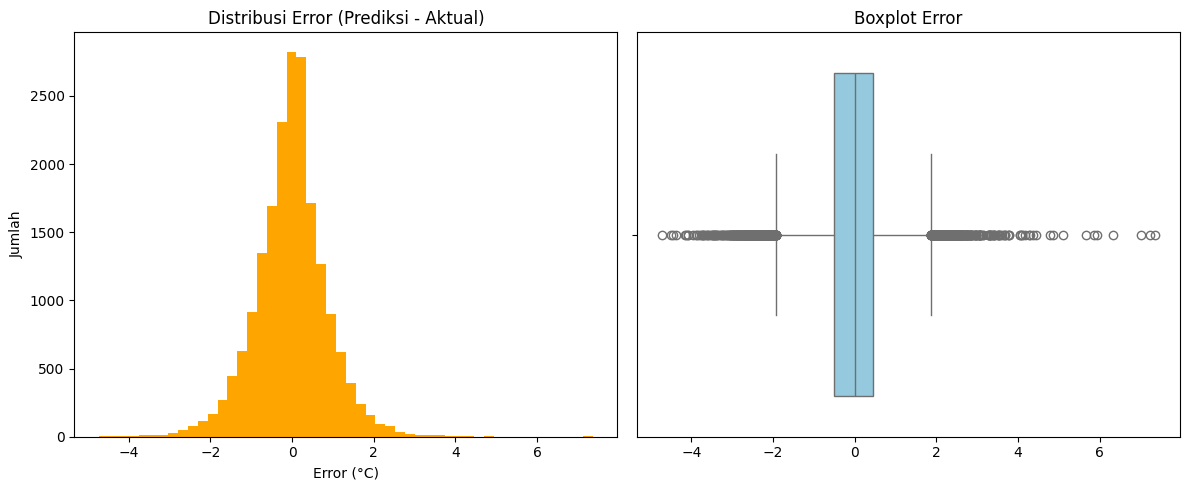

In [ ]:
errors = y_pred_celsius - y_test_celsius

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(errors, bins=50, color='orange')
plt.title("Distribusi Error (Prediksi - Aktual)")
plt.xlabel("Error (°C)")
plt.ylabel("Jumlah")

plt.subplot(1, 2, 2)
sns.boxplot(x=errors, color='skyblue')
plt.title("Boxplot Error")

plt.tight_layout()
plt.show()

***Recurrent Neural Network***

1. Load & Parse Data

In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("weatherHistory.csv")

# Konversi kolom waktu ke datetime (robust terhadap format campuran)
df["Formatted Date"] = pd.to_datetime(df["Formatted Date"], errors='coerce')

# Hapus baris yang gagal di-parse (jika ada)
df.dropna(subset=["Formatted Date"], inplace=True)

<ipython-input-7-278096423>:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df["Formatted Date"] = pd.to_datetime(df["Formatted Date"], errors='coerce')


2. Praproses Data

In [ ]:
# 1. Hapus kolom non-numerik jika ada
columns_to_drop = ["Summary", "Precip Type", "Daily Summary"]
existing_cols = [col for col in columns_to_drop if col in df.columns]

if existing_cols:
    df.drop(columns=existing_cols, inplace=True)
    print(f"✅ Kolom yang dihapus: {existing_cols}")
else:
    print(f"ℹ️ Tidak ada kolom yang dihapus dari: {columns_to_drop}")

# 2. Hapus nilai yang hilang
df.dropna(inplace=True)
print(f"✅ Jumlah baris setelah drop NA: {len(df)}")

# 3. Normalisasi semua kolom numerik (kecuali waktu)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numeric_cols = df.columns.drop("Formatted Date")
scaled_features = scaler.fit_transform(df[numeric_cols])

# 4. Gabungkan hasil scaling ke DataFrame baru
df_scaled = pd.DataFrame(scaled_features, columns=numeric_cols)
df_scaled["Formatted Date"] = df["Formatted Date"].values
df_scaled = df_scaled[["Formatted Date"] + list(numeric_cols)]

# 5. Tampilkan hasil awal
print("✅ Data berhasil dinormalisasi:")
display(df_scaled.head())

✅ Kolom yang dihapus: ['Summary', 'Precip Type', 'Daily Summary']
✅ Jumlah baris setelah drop NA: 96453
✅ Data berhasil dinormalisasi:


,Formatted Date,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
0,2006-04-01 00:00:00+02:00,0.506975,0.523486,0.89,0.221130,0.699164,0.983,0.0,0.970135
1,2006-04-01 01:00:00+02:00,0.505085,0.521084,0.86,0.223399,0.721448,0.983,0.0,0.970613
2,2006-04-01 02:00:00+02:00,0.505445,0.553144,0.89,0.061523,0.568245,0.929,0.0,0.970909
3,2006-04-01 03:00:00+02:00,0.487805,0.501947,0.83,0.220877,0.749304,0.983,0.0,0.971358
4,2006-04-01 04:00:00+02:00,0.495365,0.517356,0.83,0.172970,0.721448,0.983,0.0,0.971454


3. Dataset Info & EDA

In [ ]:
# Informasi struktur dataset
print("🔎 Struktur Dataset:")
df.info()

# Contoh data teratas
print("\n🧾 5 Baris Pertama:")
print(df.head())

# Cek missing/null values
print("\n=== Jumlah Missing Values per Kolom ===")
print(df.isnull().sum())

# Statistik deskriptif
print("\n📊 Statistik Deskriptif:")
print(df.describe())

🔎 Struktur Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Temperature (C)           96453 non-null  float64
 2   Apparent Temperature (C)  96453 non-null  float64
 3   Humidity                  96453 non-null  float64
 4   Wind Speed (km/h)         96453 non-null  float64
 5   Wind Bearing (degrees)    96453 non-null  float64
 6   Visibility (km)           96453 non-null  float64
 7   Loud Cover                96453 non-null  float64
 8   Pressure (millibars)      96453 non-null  float64
dtypes: float64(8), object(1)
memory usage: 6.6+ MB

🧾 5 Baris Pertama:
              Formatted Date  Temperature (C)  Apparent Temperature (C)  \
0  2006-04-01 00:00:00+02:00         9.472222                  7.388889   
1  2006-04-01 01:00:00+02:00         9.355556

Distribusi Target: Temperature (°C)

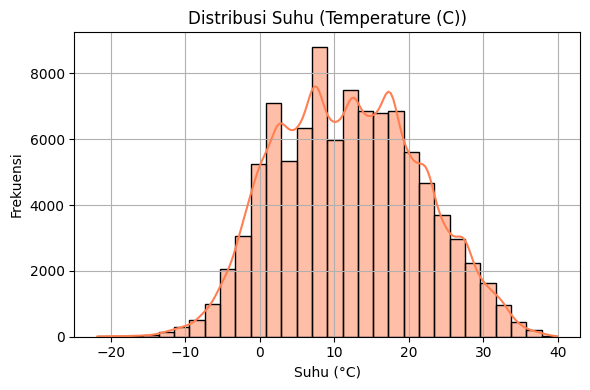

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.histplot(df["Temperature (C)"], kde=True, bins=30, color='coral')
plt.title("Distribusi Suhu (Temperature (C))")
plt.xlabel("Suhu (°C)")
plt.ylabel("Frekuensi")
plt.grid(True)
plt.tight_layout()
plt.show()

Heatmap Korelasi & Feature Selection

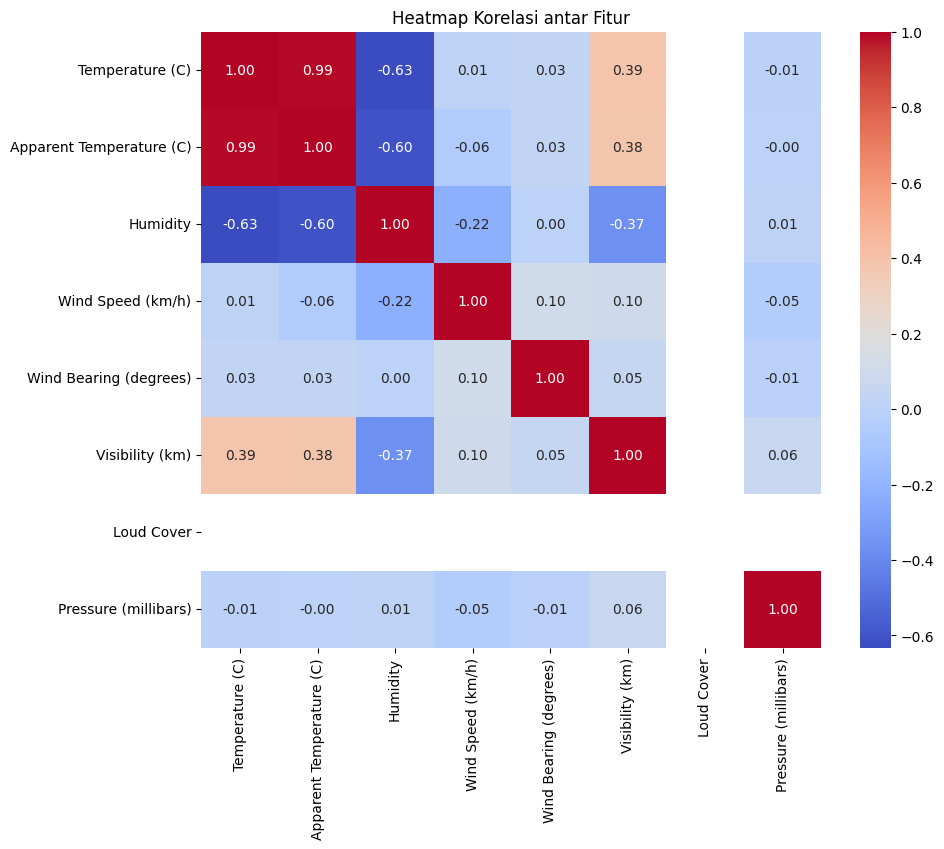


📌 Korelasi terhadap 'Temperature (C)':

Temperature (C)             1.000000
Apparent Temperature (C)    0.992629
Visibility (km)             0.392847
Wind Bearing (degrees)      0.029988
Wind Speed (km/h)           0.008957
Pressure (millibars)       -0.005447
Humidity                   -0.632255
Loud Cover                       NaN
Name: Temperature (C), dtype: float64

✅ Fitur yang dipilih berdasarkan korelasi (|corr| > 0.2):
['Apparent Temperature (C)', 'Visibility (km)', 'Humidity']


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ambil hanya kolom numerik (tanpa "Formatted Date")
numeric_df = df.select_dtypes(include=["float64", "int64"])

# Hitung korelasi antar fitur
correlation_matrix = numeric_df.corr()

# Tampilkan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap Korelasi antar Fitur")
plt.show()

# ===== Feature selection berdasarkan korelasi dengan 'Temperature (C)' =====
target_corr = correlation_matrix["Temperature (C)"].sort_values(ascending=False)
print("\n📌 Korelasi terhadap 'Temperature (C)':\n")
print(target_corr)

# Pilih fitur dengan korelasi kuat terhadap Temperature (C)
# Misal threshold korelasi minimal = 0.2
selected_features = target_corr[abs(target_corr) > 0.2].index.tolist()

# Buang 'Temperature (C)' dari daftar fitur input (karena itu target)
selected_features.remove("Temperature (C)")

print("\n✅ Fitur yang dipilih berdasarkan korelasi (|corr| > 0.2):")
print(selected_features)

4. Windowing Data untuk RNN

In [ ]:
import numpy as np
import pandas as pd

def create_rnn_dataset(data, look_back=24):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i])
        y.append(data[i][0])  # Target: suhu (kolom 0)
    return np.array(X), np.array(y)

# Ambil semua data numerik tanpa waktu
data_values = df_scaled.drop(columns=["Formatted Date"]).values
look_back = 24

# Buat window data
X, y = create_rnn_dataset(data_values, look_back)

# Tampilkan bentuk dataset
print("🔢 X shape:", X.shape)
print("🎯 y shape:", y.shape)

# Buat DataFrame untuk 1 sample (X[0])
window_df = pd.DataFrame(X[0], columns=df_scaled.columns[1:])  # Buang "Formatted Date"
print("\n📊 Input (24 jam terakhir - scaled):")
display(window_df)

# Tampilkan target dalam bentuk DataFrame
target_scaled = y[0]

# ✅ Perbaikan di sini
dummy_input = np.zeros((1, 8))
dummy_input[0, 0] = target_scaled
target_actual = scaler.inverse_transform(dummy_input)[0][0]

target_df = pd.DataFrame({
    "Target suhu (scaled)": [target_scaled],
    "Target suhu (°C)": [round(target_actual, 2)]
})

print("\n🎯 Target suhu:")
display(target_df)

🔢 X shape: (96429, 24, 8)
🎯 y shape: (96429,)

📊 Input (24 jam terakhir - scaled):


,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
0,0.506975,0.523486,0.89,0.221130,0.699164,0.983,0.0,0.970135
1,0.505085,0.521084,0.86,0.223399,0.721448,0.983,0.0,0.970613
2,0.505445,0.553144,0.89,0.061523,0.568245,0.929,0.0,0.970909
3,0.487805,0.501947,0.83,0.220877,0.749304,0.983,0.0,0.971358
4,0.495365,0.517356,0.83,0.172970,0.721448,0.983,0.0,0.971454
5,0.502925,0.519344,0.85,0.218608,0.718663,0.929,0.0,0.971597
6,0.478805,0.495651,0.95,0.193646,0.721448,0.620,0.0,0.971655
7,0.495635,0.510645,0.89,0.221634,0.724234,0.620,0.0,0.971769
8,0.528845,0.574683,0.82,0.177257,0.721448,0.620,0.0,0.972276
9,0.576636,0.618673,0.72,0.196167,0.777159,0.620,0.0,0.972132



🎯 Target suhu:


,Target suhu (scaled),Target suhu (°C)
0,0.522365,10.42


5. Split Train/Val/Test

In [ ]:
from sklearn.model_selection import train_test_split

# Split data: train 70%, val 15%, test 15%
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

print("Train set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

Train set: (67500, 24, 8)
Validation set: (14464, 24, 8)
Test set: (14465, 24, 8)


6. Bangun Model RNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

model = Sequential([
    SimpleRNN(64, activation='tanh', input_shape=(look_back, X.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,737 (18.50 KB)

 Trainable params: 4,737 (18.50 KB)

 Non-trainable params: 0 (0.00 B)

7. Train Model

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val)
)

Epoch 1/20
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0157 - mae: 0.0626 - val_loss: 7.4877e-04 - val_mae: 0.0207
Epoch 2/20
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 7.7217e-04 - mae: 0.0199 - val_loss: 5.0333e-04 - val_mae: 0.0159
Epoch 3/20
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 7.0077e-04 - mae: 0.0187 - val_loss: 5.8767e-04 - val_mae: 0.0179
Epoch 4/20
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 7.0926e-04 - mae: 0.0186 - val_loss: 4.6002e-04 - val_mae: 0.0149
Epoch 5/20
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 6.3963e-04 - mae: 0.0176 - val_loss: 4.3090e-04 - val_mae: 0.0145
Epoch 6/20
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 6.1750e-04 - mae: 0.0171 - val_loss: 5.1313e-04 - val_mae: 0.0165
Epoch 7/20
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 6.0911e-04 - mae: 0.0173 - val_loss: 4.0321e-04 - val_mae: 0.0137
Epoch 8/20
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 5.9816e-04 - mae: 0.0168 - val_lo

8. Evaluasi Model (RMSE & MAE)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Prediksi
y_pred = model.predict(X_test)

# ✅ Buat dummy array dengan 8 kolom
y_pred_dummy = np.zeros((len(y_pred), 8))
y_pred_dummy[:, 0] = y_pred.flatten()  # Masukkan prediksi suhu ke kolom ke-0
y_test_dummy = np.zeros((len(y_test), 8))
y_test_dummy[:, 0] = y_test.flatten()  # Masukkan nilai asli suhu ke kolom ke-0

# ✅ Inverse transform seluruh dummy array
y_pred_inv = scaler.inverse_transform(y_pred_dummy)[:, 0]  # Ambil kolom suhu
y_test_inv = scaler.inverse_transform(y_test_dummy)[:, 0]  # Ambil kolom suhu

# Hitung error
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print("📉 RMSE:", rmse)
print("📉 MAE:", mae)

453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
📉 RMSE: 1.1829499312976413
📉 MAE: 0.8468772869520068


9. Visualisasi Loss Curve

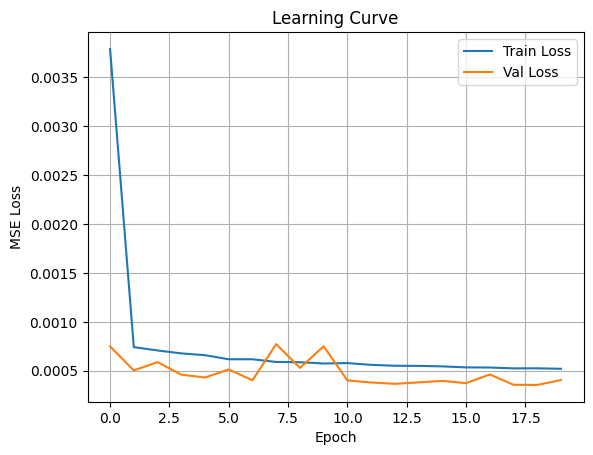

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

10. Visualisasi Prediksi vs Aktual

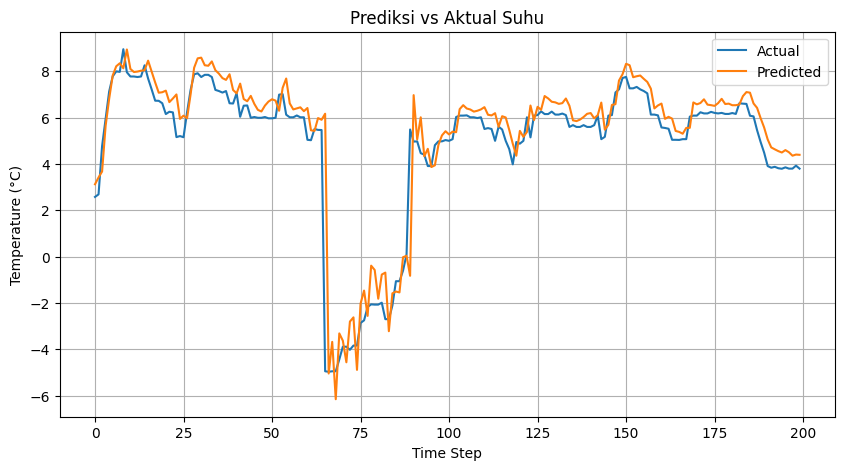

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv[:200], label='Actual')
plt.plot(y_pred_inv[:200], label='Predicted')
plt.title('Prediksi vs Aktual Suhu')
plt.xlabel('Time Step')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

11. Visualisasi SCatter Error

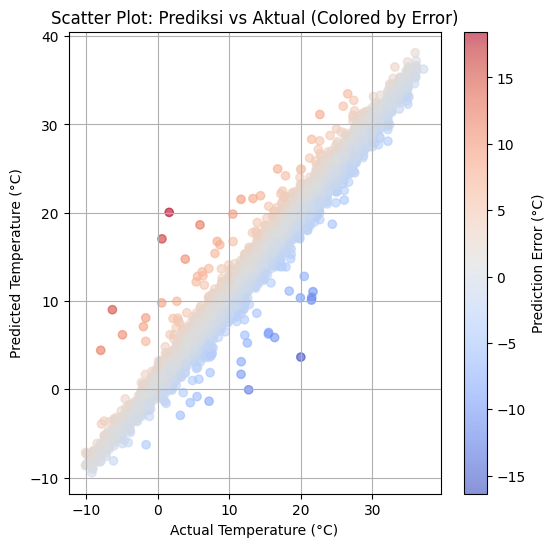

In [ ]:
import numpy as np

errors = y_pred_inv - y_test_inv  # Error per titik
plt.figure(figsize=(6, 6))
scatter = plt.scatter(y_test_inv, y_pred_inv, c=errors, cmap='coolwarm', alpha=0.6)
plt.colorbar(scatter, label='Prediction Error (°C)')
plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("Scatter Plot: Prediksi vs Aktual (Colored by Error)")
plt.grid(True)
plt.show()